In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import pathlib
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


TF version: 2.15.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [2]:

path = "Data"
os.listdir(path)

['test', 'Train']

In [3]:
TRAIN_DIR = os.path.join(path, "Train")
VAL_DIR = os.path.join(path, "test")

In [5]:
#Fixer la taille des images et du batch
BATCH_SIZE=16
IMG_SIZE= (224,224)

In [ ]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    shuffle = True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode="categorical",
    shuffle = True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)


Found 1215 files belonging to 4 classes.
Found 340 files belonging to 4 classes.


In [7]:
class_names = tuple(train_ds.class_names)
# class_names = np.array(train_ds.class_names)
class_names

('Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil')

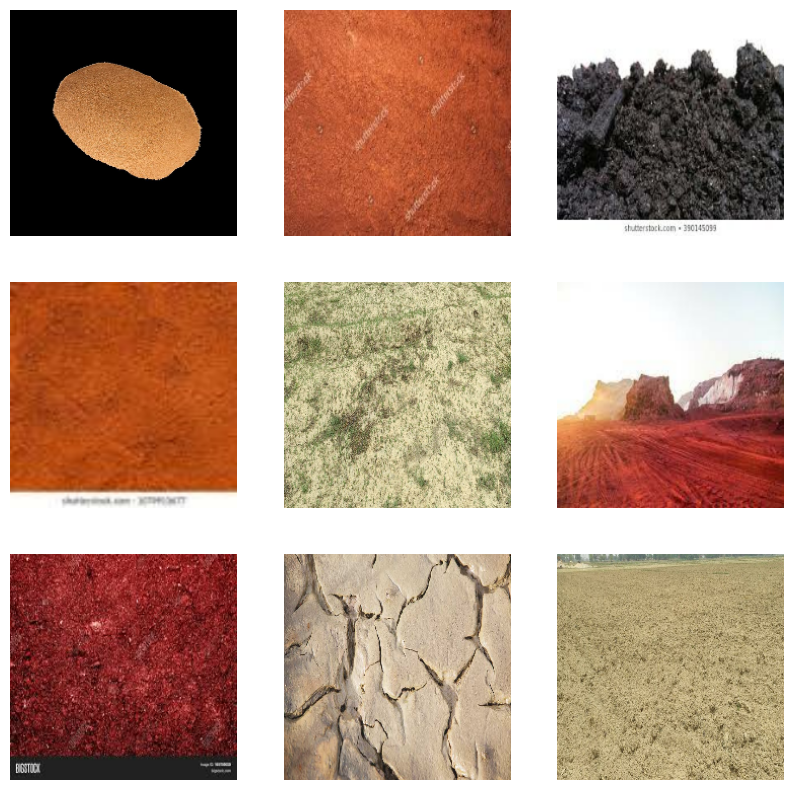

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:

train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    preprocessing_model.add(
      tf.keras.layers.RandomRotation(20))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_data = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
validation_datat = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

In [10]:

for image_batch, label_batch in train_ds:
    break
image_batch.shape, label_batch.shape

(TensorShape([16, 224, 224, 3]), TensorShape([16, 4]))

In [11]:
model_handle = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 4)                 4008      
                                                                 
Total params: 3544273 (13.52 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
          validation_data=validation_datat,
          epochs=30,
          steps_per_epoch=train_size,
          validation_steps= valid_size
         )

Epoch 1/30



76/76 [==============================] - 69s 830ms/step - loss: 1.7719 - accuracy: 0.3630 - val_loss: 1.6238 - val_accuracy: 0.3912
Epoch 2/30
76/76 [==============================] - 113s 2s/step - loss: 1.1806 - accuracy: 0.5695 - val_loss: 1.2764 - val_accuracy: 0.5324
Epoch 3/30
76/76 [==============================] - 24s 320ms/step - loss: 0.9234 - accuracy: 0.6527 - val_loss: 1.1183 - val_accuracy: 0.5824
Epoch 4/30
76/76 [==============================] - 25s 332ms/step - loss: 0.7988 - accuracy: 0.7012 - val_loss: 0.9929 - val_accuracy: 0.6294
Epoch 5/30
76/76 [==============================] - 25s 335ms/step - loss: 0.7256 - accuracy: 0.7210 - val_loss: 0.9115 - val_accuracy: 0.6471
Epoch 6/30
76/76 [==============================] - 26s 350ms/step - loss: 0.6509 - accuracy: 0.7671 - val_loss: 0.8538 - val_accuracy: 0.6706
Epoch 7/30
76/76 [==============================] - 26s 345ms/step - loss: 0.6098 - accuracy: 0.7728 - val_loss: 0.8073 - val_accuracy: 0.7000
Epoch 8/30
7

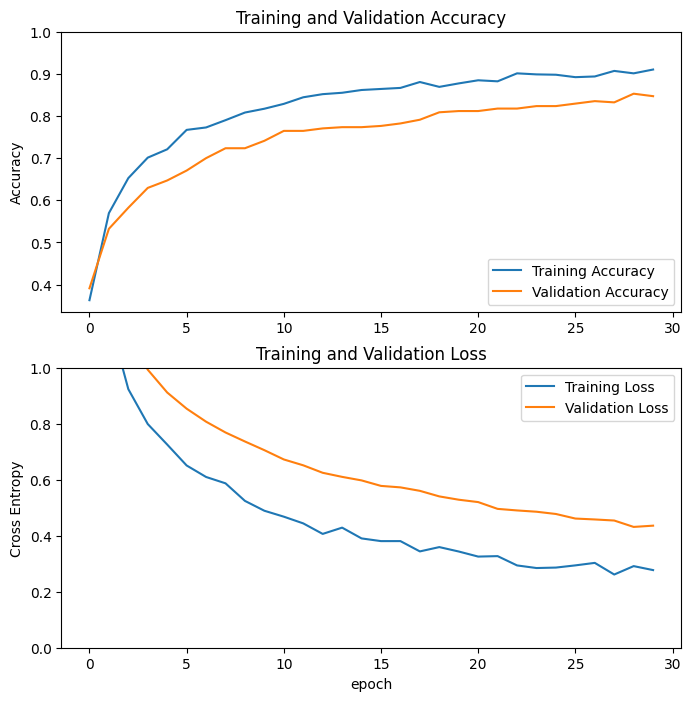

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')#
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
do_fine_tuning = True
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_1 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 3,544,273
Trainable params: 3,510,161
Non-trainable params: 34,112
_________________________________________________________________


In [18]:
model.save("soil.h5")

c:\Users\saidi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
new_model = tf.keras.models.load_model('soil.h5', custom_objects={'KerasLayer':hub.KerasLayer})

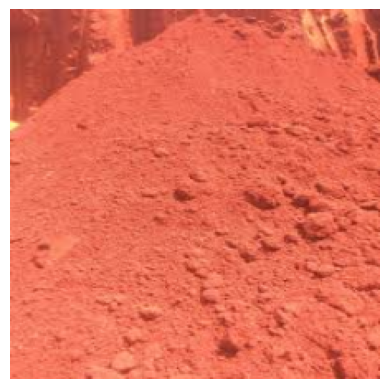

1/1 [==============================] - 1s 503ms/step
True label: Red soil
Predicted label: Red soil


In [ ]:
x, y = next(iter(validation_datat))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = new_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

22/22 [==============================] - 3s 117ms/step
               precision    recall  f1-score   support

Alluvial soil       0.08      0.09      0.09        53
   Black Soil       0.33      0.28      0.30       116
    Clay soil       0.23      0.25      0.24        65
     Red soil       0.32      0.33      0.33       106

     accuracy                           0.26       340
    macro avg       0.24      0.24      0.24       340
 weighted avg       0.27      0.26      0.26       340



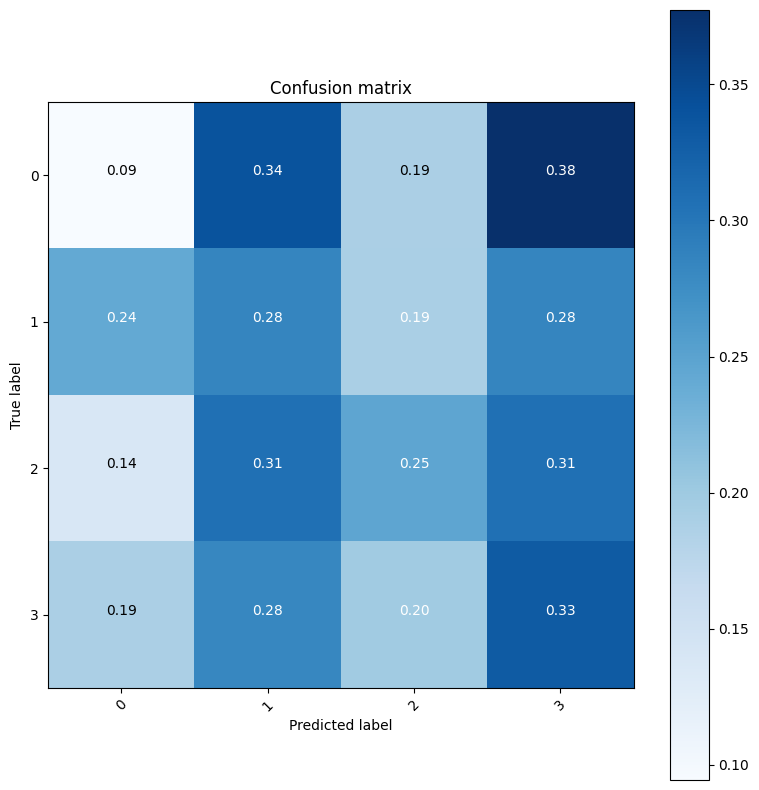

In [22]:
#plot confusion matrix for multiclass classification
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Predict the values from the validation dataset
Y_pred = new_model.predict(validation_datat)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = []
for images, labels in validation_datat:
    Y_true.append(labels.numpy())
Y_true = np.concatenate(Y_true)
Y_true = np.argmax(Y_true, axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

#Classification report
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))